# Infosys Springboard Project

## (by Prakarsh Mathur)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Vanilla LSTM

In [4]:
data = pd.read_csv('social_media_engagement_dataset.csv') # here I had loaded the dataset using pandas
data.head() # here I printed the first 5 rows of dataset

,Date,New_Users_Registered,Daily_Active_Users,Posts_Created,Likes_Given,Comments_Made,Shares,Ad_Revenue
0,2023-01-01,192,4497,1518,9781,3008,814,2347.56
1,2023-01-02,171,4588,1502,10114,3014,784,2159.56
2,2023-01-03,200,4902,1525,10030,2975,801,2141.88
3,2023-01-04,207,5218,1503,10085,3018,804,1642.98
4,2023-01-05,202,5074,1466,10158,2843,762,1672.86


In [5]:
data.info() # checked for datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1000 non-null   object 
 1   New_Users_Registered  1000 non-null   int64  
 2   Daily_Active_Users    1000 non-null   int64  
 3   Posts_Created         1000 non-null   int64  
 4   Likes_Given           1000 non-null   int64  
 5   Comments_Made         1000 non-null   int64  
 6   Shares                1000 non-null   int64  
 7   Ad_Revenue            1000 non-null   float64
dtypes: float64(1), int64(6), object(1)
memory usage: 62.6+ KB


In [6]:
data['Date'] = pd.to_datetime(data['Date']) # converted 'Date' to datetime format
data = data.sort_values('Date').reset_index(drop=True) # sorted the date in chronological order and then reset its indexing

In [7]:
data

,Date,New_Users_Registered,Daily_Active_Users,Posts_Created,Likes_Given,Comments_Made,Shares,Ad_Revenue
0,2023-01-01,192,4497,1518,9781,3008,814,2347.56
1,2023-01-02,171,4588,1502,10114,3014,784,2159.56
2,2023-01-03,200,4902,1525,10030,2975,801,2141.88
3,2023-01-04,207,5218,1503,10085,3018,804,1642.98
4,2023-01-05,202,5074,1466,10158,2843,762,1672.86
...,...,...,...,...,...,...,...,...
995,2025-09-22,187,5076,1538,10083,2856,815,2089.48
996,2025-09-23,183,5372,1427,9995,3056,851,1816.23
997,2025-09-24,191,5259,1421,10131,2978,804,2292.80
998,2025-09-25,192,5150,1517,10159,3001,770,1957.53


In [8]:
data.isnull().sum() # checked for null values

Date                    0
New_Users_Registered    0
Daily_Active_Users      0
Posts_Created           0
Likes_Given             0
Comments_Made           0
Shares                  0
Ad_Revenue              0
dtype: int64

In [9]:
new_d = data.drop(columns=['Date']) #we have to drop date column as it is in datetime type, where operation cannot be performed

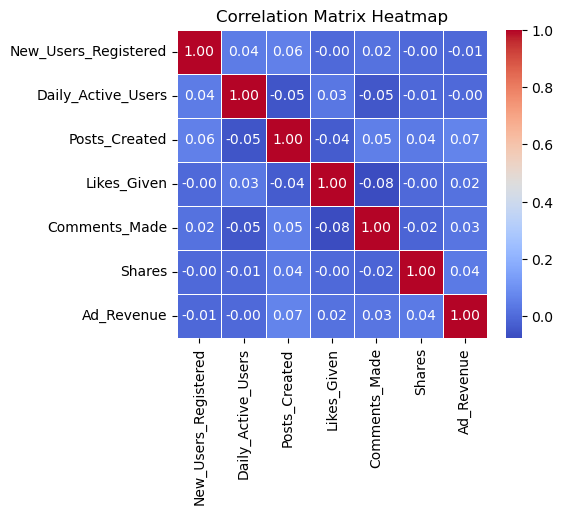

In [10]:
correlation_matrix = new_d.corr()

plt.figure(figsize=(5, 4)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [11]:
def detect_outliers(new_d, threshold=3): #checked for any outliers
    z_scores = np.abs(new_d.apply(zscore))  # compute Z-scores
    outliers = (z_scores > threshold).any(axis=1)  # identified rows with any feature > threshold
    return outliers

#outliers = detect_outliers(new_d)
#print("Number of outliers = ", outliers.sum())

In [12]:
#z_scores = np.abs(new_d.apply(zscore))
#new_d = new_d[(z_scores < 2).all(axis=1)] #removed outliers using the Z-score method

In [13]:
outliers = detect_outliers(new_d)
print("Number of outliers = ", outliers.sum())

Number of outliers =  18


In [14]:
scaler = MinMaxScaler() #scaled the data using MinMaxScaler
scaled_d = scaler.fit_transform(new_d)
scaled_d = pd.DataFrame(scaled_d, columns=new_d.columns) #converted scaled data back to dataframe

In [15]:
scaled_d.head()

,New_Users_Registered,Daily_Active_Users,Posts_Created,Likes_Given,Comments_Made,Shares,Ad_Revenue
0,0.397727,0.195070,0.536122,0.096386,0.487437,0.551351,0.763272
1,0.159091,0.243837,0.475285,0.597892,0.502513,0.389189,0.628727
2,0.488636,0.412111,0.562738,0.471386,0.404523,0.481081,0.616074
3,0.568182,0.581458,0.479087,0.554217,0.512563,0.497297,0.259028
4,0.511364,0.504287,0.338403,0.664157,0.072864,0.270270,0.280412


In [16]:
target = data['Ad_Revenue'].values.reshape(-1, 1) # Ad_Revenue as the feature

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1)) # normalizing the target feature
scaled_t = scaler.fit_transform(target)

In [18]:
def create_sequences(data, sequence):
    X, y = [], []
    for i in range(len(data) - sequence):
        X.append(data[i:i + sequence])
        y.append(data[i + sequence])
    return np.array(X), np.array(y)

sequence = 10
X, y = create_sequences(scaled_t, sequence)

In [19]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [21]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence, 1),dropout=0.2, recurrent_dropout=0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


In [22]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1) #training the model

Epoch 1/100
25/25 [==============================] - 16s 112ms/step - loss: 0.1277 - val_loss: 0.0263
Epoch 2/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0276 - val_loss: 0.0242
Epoch 3/100
25/25 [==============================] - 1s 37ms/step - loss: 0.0226 - val_loss: 0.0226
Epoch 4/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0229 - val_loss: 0.0221
Epoch 5/100
25/25 [==============================] - 1s 41ms/step - loss: 0.0228 - val_loss: 0.0218
Epoch 6/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0224 - val_loss: 0.0232
Epoch 7/100
25/25 [==============================] - 1s 38ms/step - loss: 0.0214 - val_loss: 0.0225
Epoch 8/100
25/25 [==============================] - 1s 36ms/step - loss: 0.0219 - val_loss: 0.0258
Epoch 9/100
25/25 [==============================] - 1s 37ms/step - loss: 0.0219 - val_loss: 0.0223
Epoch 10/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0215 - val_loss: 0.02

25/25 [==============================] - 1s 37ms/step - loss: 0.0208 - val_loss: 0.0218
Epoch 83/100
25/25 [==============================] - 1s 39ms/step - loss: 0.0210 - val_loss: 0.0221
Epoch 84/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0211 - val_loss: 0.0214
Epoch 85/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0210 - val_loss: 0.0215
Epoch 86/100
25/25 [==============================] - 1s 42ms/step - loss: 0.0209 - val_loss: 0.0214
Epoch 87/100
25/25 [==============================] - 1s 38ms/step - loss: 0.0210 - val_loss: 0.0219
Epoch 88/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0210 - val_loss: 0.0214
Epoch 89/100
25/25 [==============================] - 1s 36ms/step - loss: 0.0209 - val_loss: 0.0214
Epoch 90/100
25/25 [==============================] - 1s 37ms/step - loss: 0.0209 - val_loss: 0.0215
Epoch 91/100
25/25 [==============================] - 1s 41ms/step - loss: 0.0210 - val_loss: 0.0216
Epo

In [23]:
mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test data: {mse:.4f}")

Mean Squared Error on test data: 0.0215


In [24]:
predictions = model.predict(X_test)

7/7 [==============================] - 2s 13ms/step


In [25]:
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(predictions)

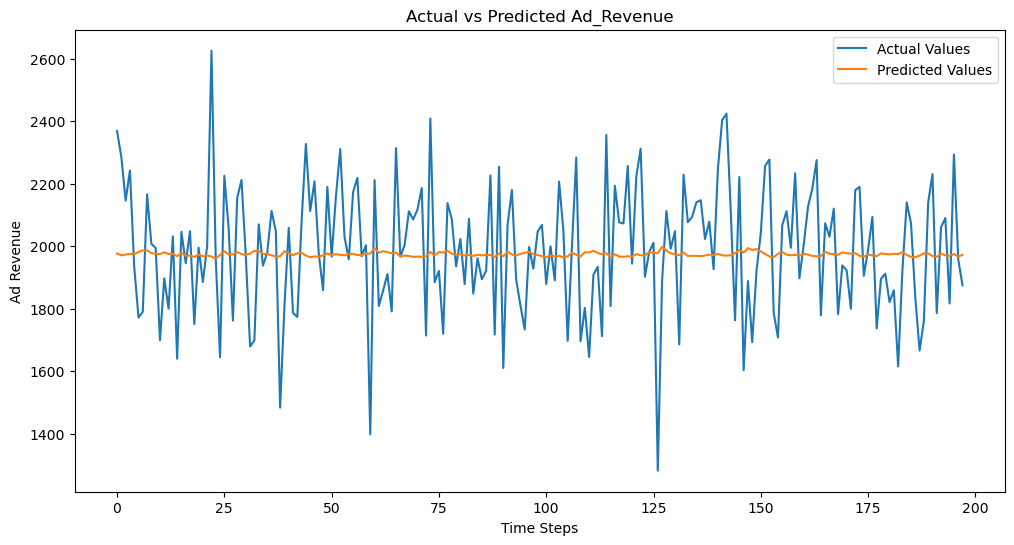

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual Values')
plt.plot(y_pred_original, label='Predicted Values')
plt.title('Actual vs Predicted Ad_Revenue')
plt.xlabel('Time Steps')
plt.ylabel('Ad Revenue')
plt.legend()
plt.show()

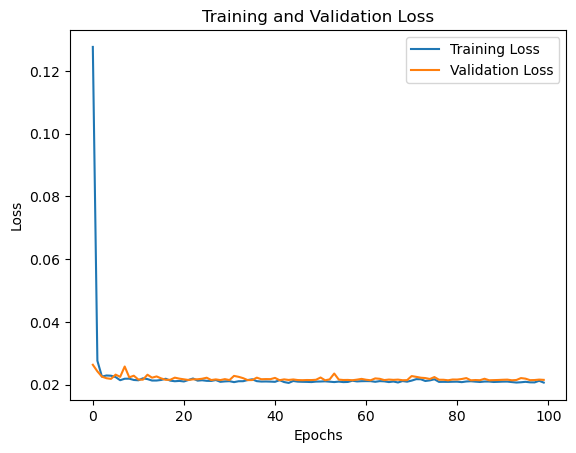

In [27]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


### Stacked LSTM

In [29]:
model2 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])


model2.compile(optimizer='adam', loss='mean_squared_error') # compiling the model

In [30]:
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
25/25 [==============================] - 30s 261ms/step - loss: 0.0651 - val_loss: 0.0234
Epoch 2/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0243 - val_loss: 0.0236
Epoch 3/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0249 - val_loss: 0.0224
Epoch 4/100
25/25 [==============================] - 1s 54ms/step - loss: 0.0233 - val_loss: 0.0226
Epoch 5/100
25/25 [==============================] - 1s 52ms/step - loss: 0.0230 - val_loss: 0.0223
Epoch 6/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0227 - val_loss: 0.0227
Epoch 7/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0230 - val_loss: 0.0234
Epoch 8/100
25/25 [==============================] - 1s 49ms/step - loss: 0.0236 - val_loss: 0.0219
Epoch 9/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0222 - val_loss: 0.0218
Epoch 10/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0227 - val_loss: 0.02

25/25 [==============================] - 1s 50ms/step - loss: 0.0208 - val_loss: 0.0214
Epoch 83/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0209 - val_loss: 0.0215
Epoch 84/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0210 - val_loss: 0.0214
Epoch 85/100
25/25 [==============================] - 1s 57ms/step - loss: 0.0210 - val_loss: 0.0216
Epoch 86/100
25/25 [==============================] - 1s 49ms/step - loss: 0.0208 - val_loss: 0.0214
Epoch 87/100
25/25 [==============================] - 1s 57ms/step - loss: 0.0208 - val_loss: 0.0220
Epoch 88/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0211 - val_loss: 0.0216
Epoch 89/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0210 - val_loss: 0.0215
Epoch 90/100
25/25 [==============================] - 1s 52ms/step - loss: 0.0207 - val_loss: 0.0214
Epoch 91/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0207 - val_loss: 0.0215
Epo

In [32]:
predictions2 = model2.predict(X_test)

7/7 [==============================] - 5s 14ms/step


In [33]:
rescaled_pred2 = scaler.inverse_transform(predictions2.reshape(-1, 1))

In [34]:
y_test_rescaled2 = scaler.inverse_transform(y_test.reshape(-1, 1))


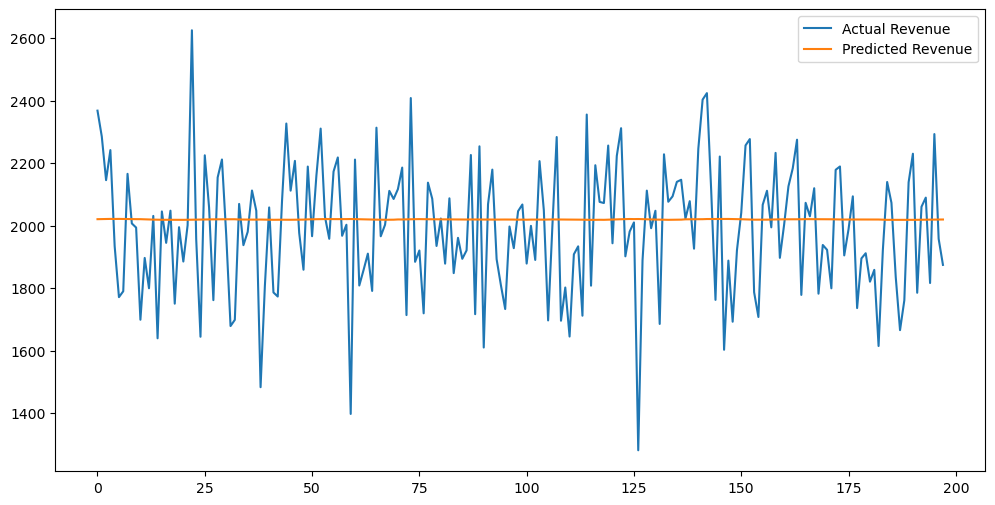

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled2, label='Actual Revenue')
plt.plot(rescaled_pred2, label='Predicted Revenue')
plt.legend()
plt.show()

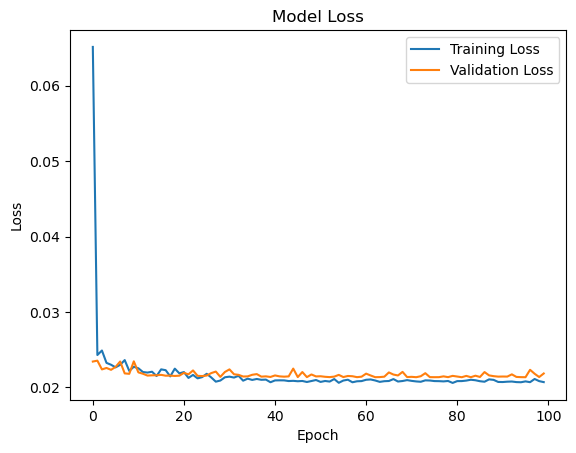

In [36]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [37]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          
    restore_best_weights=True  
)


In [38]:
history3 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 2s 62ms/step - loss: 0.0208 - val_loss: 0.0215
Epoch 2/100
25/25 [==============================] - 1s 54ms/step - loss: 0.0209 - val_loss: 0.0216
Epoch 3/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0208 - val_loss: 0.0221
Epoch 4/100
25/25 [==============================] - 1s 52ms/step - loss: 0.0209 - val_loss: 0.0215
Epoch 5/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0208 - val_loss: 0.0214
Epoch 6/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0208 - val_loss: 0.0214
Epoch 7/100
25/25 [==============================] - 1s 54ms/step - loss: 0.0208 - val_loss: 0.0216
Epoch 8/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0209 - val_loss: 0.0217
Epoch 9/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0207 - val_loss: 0.0214
Epoch 10/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0207 - val_loss: 0.0214

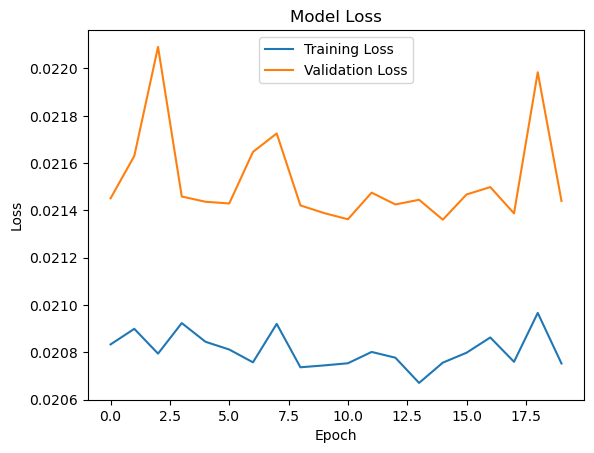

In [39]:
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [40]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 25)               

### Bidirectional LSTM

In [41]:
from keras.layers import Bidirectional

In [42]:
steps = 10
X, y = create_sequences(scaled_t, steps)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [44]:
model3 = Sequential([
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32, activation='tanh')),
    Dropout(0.2),
    Dense(1) 
])
 

In [45]:
model3.compile(optimizer='adam', loss='mse')

In [46]:
history4 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Epoch 1/20
25/25 [==============================] - 36s 317ms/step - loss: 0.0561 - val_loss: 0.0283
Epoch 2/20
25/25 [==============================] - 1s 50ms/step - loss: 0.0261 - val_loss: 0.0233
Epoch 3/20
25/25 [==============================] - 1s 50ms/step - loss: 0.0228 - val_loss: 0.0233
Epoch 4/20
25/25 [==============================] - 1s 52ms/step - loss: 0.0235 - val_loss: 0.0233
Epoch 5/20
25/25 [==============================] - 1s 52ms/step - loss: 0.0233 - val_loss: 0.0243
Epoch 6/20
25/25 [==============================] - 1s 49ms/step - loss: 0.0235 - val_loss: 0.0236
Epoch 7/20
25/25 [==============================] - 1s 49ms/step - loss: 0.0238 - val_loss: 0.0226
Epoch 8/20
25/25 [==============================] - 1s 55ms/step - loss: 0.0230 - val_loss: 0.0224
Epoch 9/20
25/25 [==============================] - 1s 53ms/step - loss: 0.0228 - val_loss: 0.0223
Epoch 10/20
25/25 [==============================] - 1s 52ms/step - loss: 0.0225 - val_loss: 0.0222
Epoch 1

In [116]:
train_loss = model3.evaluate(X_train, y_train, verbose=0)
test_loss = model3.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Train Loss: 0.0208, Test Loss: 0.0217


In [117]:
y_pred3 = model3.predict(X_test)
y_pred_rescaled3 = scaler.inverse_transform(y_pred3)
y_test_rescaled3 = scaler.inverse_transform(y_test)

7/7 [==============================] - 7s 14ms/step


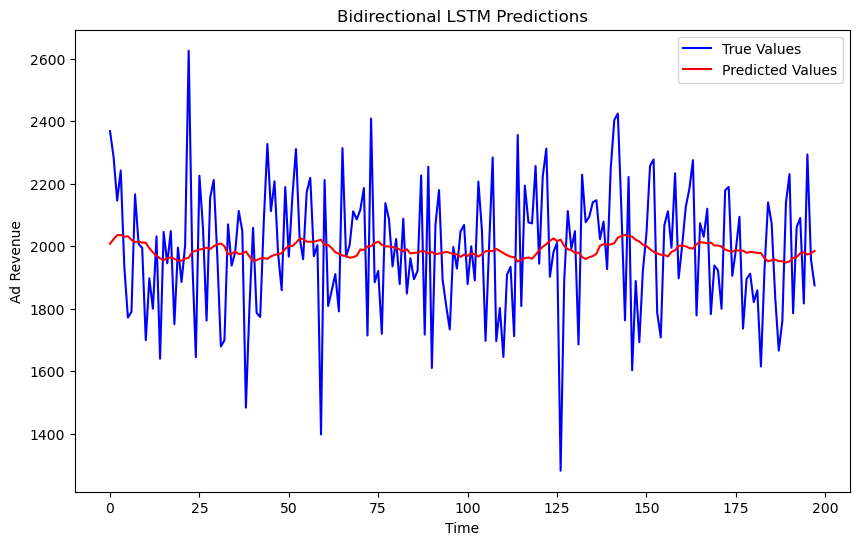

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled3, label='True Values', color='blue')
plt.plot(y_pred_rescaled3, label='Predicted Values', color='red')
plt.title('Bidirectional LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('Ad Revenue')
plt.legend()
plt.show()

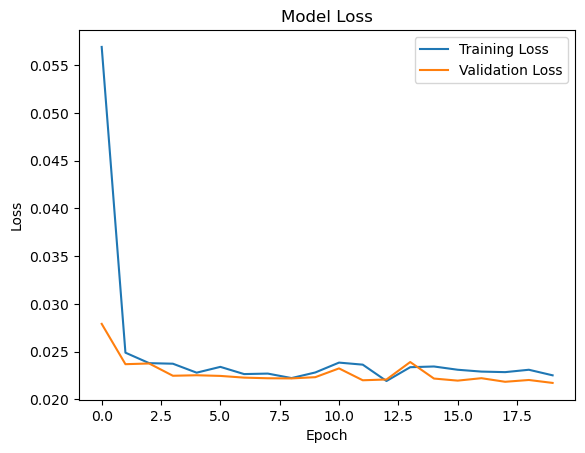

In [119]:
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()
